In [1]:
%matplotlib inline
import logging
import datetime
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from pylab import rcParams

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, GaussianNoise
from keras import backend as K
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.advanced_activations import ReLU
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import SGD
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model


Using TensorFlow backend.


In [3]:
# memoryの制限
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

In [ ]:
#Tuning
dataset = "ModelNet10"
# dataset = "ModelNet40"
cells = 32
batch_size = 128
epochs = 2
learning_rate = 0.01

In [ ]:
if dataset == "ModelNet10":
    data_dir = "data10/cell" + str(cells) + "/"
    fig_dir = "fig10/cell" + str(cells) + "/"
    weights_dir = "weights10/cell" + str(cells) + "/"
    num_classes = 10
    class_name_modelnet = [
    'bathtub',
    'chair',
    'dresser',
    'night_stand',
    'table',
    'bed',
    'desk',
    'monitor',
    'sofa',
    'toilet',
    ]

In [ ]:
if dataset == "ModelNet40":
    data_dir = "data40/cell" + str(cells) + "/"
    fig_dir = "fig40/cell" + str(cells) + "/"
    weights_dir = "weights40/cell" + str(cells) + "/"
    num_classes = 40
    class_name_modelnet = [
    'airplane',
    'bookshelf',
    'chair',
    'desk',
    'glass_box',
    'laptop',
    'person',
    'range_hood',
    'stool',
    'tv_stand',
    'bathtub',
    'bottle',
    'cone',
    'door',
    'guitar',
    'mantel',
    'piano',
    'sink',
    'table',
    'vase',
    'bed',
    'bowl',
    'cup',
    'dresser',
    'keyboard',
    'monitor',
    'plant',
    'sofa',
    'tent',
    'wardrobe',
    'bench',
    'car',
    'curtain',
    'flower_pot',
    'lamp',
    'night_stand',
    'radio',
    'stairs',
    'toilet',
    'xbox',
    ]

In [ ]:
train_or_test = ["train","test"]

In [ ]:
if os.path.exists(weights_dir) == False:
    os.makedirs(weights_dir)
if os.path.exists(fig_dir) == False:
    os.makedirs(fig_dir)

In [8]:
#set logging level DEBUG and output to stdout
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [9]:
# optimizer = SGD(lr=0.01, momentum=0.9, decay=0.00016667, nesterov=False)
optimizer = SGD(lr=learning_rate, momentum=0.9, decay=0.00016667, nesterov=False)

# init model
model = Sequential()

# convolution 1
model.add(Conv3D(input_shape=(1, cells, cells, cells),
                            nb_filter=32,
                            kernel_dim1=5,
                            kernel_dim2=5,
                            kernel_dim3=5,
                            init='normal',
                            border_mode='valid',
                            subsample=(2, 2, 2),
                            dim_ordering='th',
                            W_regularizer=l2(0.001),
                            b_regularizer=l2(0.001),
                            ))

# # BatchNormalization 1
# model.add(BatchNormalization(axis=-1, 
#                              momentum=0.99, 
#                              epsilon=0.001, 
#                              center=True, 
#                              scale=True, 
#                              beta_initializer='zeros', 
#                              gamma_initializer='ones', 
#                              moving_mean_initializer='zeros', 
#                              moving_variance_initializer='ones', 
#                              beta_regularizer=None, 
#                              gamma_regularizer=None, 
#                              beta_constraint=None, 
#                              gamma_constraint=None))



#Activation ReLu
model.add(Activation(ReLU()))

# dropout 1
model.add(Dropout(p=0.4))

# convolution 2
model.add(Conv3D(nb_filter=32,
                            kernel_dim1=3,
                            kernel_dim2=3,
                            kernel_dim3=3,
                            init='normal',
                            border_mode='valid',
                            subsample=(1, 1, 1),
                            dim_ordering='th',
                            W_regularizer=l2(0.001),
                            b_regularizer=l2(0.001),
                            ))

# # BatchNormalization 2
# model.add(BatchNormalization(axis=-1, 
#                              momentum=0.99, 
#                              epsilon=0.001, 
#                              center=True, 
#                              scale=True, 
#                              beta_initializer='zeros', 
#                              gamma_initializer='ones', 
#                              moving_mean_initializer='zeros', 
#                              moving_variance_initializer='ones', 
#                              beta_regularizer=None, 
#                              gamma_regularizer=None, 
#                              beta_constraint=None, 
#                              gamma_constraint=None))

#Activation ReLu
model.add(Activation(ReLU()))

# max pool 1
model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           strides=None,
                           border_mode='valid',
                           dim_ordering='th'))

# dropout 2
model.add(Dropout(p=0.4))

# dense 1 (fully connected layer)
model.add(Flatten())

model.add(Dense(output_dim=528, #128
                    init='normal',
                    activation='linear',
                    W_regularizer=l2(0.001),
                    b_regularizer=l2(0.001),
                    ))

# dropout 3
model.add(Dropout(p=0.5))

# dense 2 (fully connected layer)
model.add(Dense(output_dim=num_classes,
                    init='normal',
                    activation='linear',
                    W_regularizer=l2(0.001),
                    b_regularizer=l2(0.001),
                    ))

#Activation Softmax
model.add(Activation("softmax"))

# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])


/home/takitani/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(input_shape=(1, 32, 32..., kernel_size=(5, 5, 5), filters=32, strides=(2, 2, 2), padding="valid", data_format="channels_first", kernel_initializer="normal", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg...)`
/home/takitani/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/keras/activations.py:186: UserWarning: Do not pass a layer instance (such as ReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/takitani/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.4)`
/home/takitani/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launc

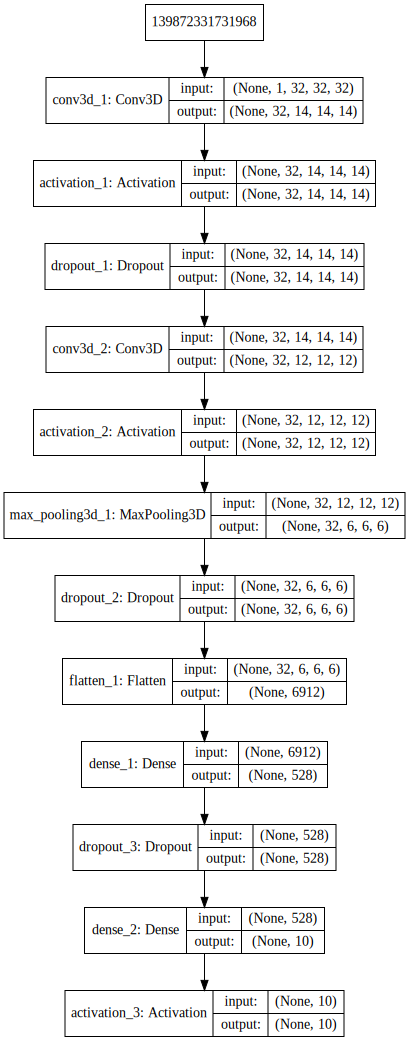

In [10]:
#可視化
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [11]:
#サマリーの表示
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 32, 14, 14, 14)    4032      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 14, 14, 14)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 14, 14, 14)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 12, 12, 12)    27680     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 12, 12, 12)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 6, 6, 6)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 6, 6, 6)       0         
__________

In [12]:
#モデルの図を保存
plot_model(model, to_file=fig_dir + 'model.png',show_shapes='True')

In [13]:
model

In [14]:
x_train = np.load( data_dir  + "x_train.npy")
x_test = np.load( data_dir  + "x_test.npy")
y_train = np.load( data_dir + "y_train.npy")
y_test = np.load( data_dir + "y_test.npy")

In [15]:
x_train.shape

(3991, 1, 32, 32, 32)

In [16]:
y_train.shape

(3991, 10)

In [17]:
x_test.shape

(908, 1, 32, 32, 32)

In [18]:
y_test.shape

(908, 10)

In [ ]:
# es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

In [21]:
result = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(x_test, y_test))
#                    callbacks=[es_cb])

time_now = datetime.datetime.now()
time_now = "_{0}_{1}_{2}_{3}_{4}_{5}".format(time_now.year, time_now.month, time_now.day,
                                             time_now.hour, time_now.minute, time_now.second)
logging.info("save model weights as [weights_{0}.h5]".format(time_now))
model.save_weights(weights_dir+"weights_{0}.h5".format(time_now), False)

Train on 3991 samples, validate on 908 samples
Epoch 1/2


ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[Node: conv3d_1/weight_regularizer/mul/x = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0.001>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

In [ ]:
loss,acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

In [ ]:
rcParams["figure.figsize"] = [6.4, 4.8]

In [ ]:
plt.plot(range(1, len(result.history['acc'])+1), result.history['acc'], label="training")
plt.plot(range(1, len(result.history['val_acc'])+1), result.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend()
plt.title(" {} / cell {}".format(dataset,cells))
plt.savefig(fig_dir + 'acc.svg')
plt.show()

In [ ]:
plt.plot(range(1, len(result.history['loss'])+1), result.history['loss'], label="loss")
plt.plot(range(1, len(result.history['val_loss'])+1), result.history['val_loss'], label="validation_loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.title(" {} / cell {}".format(dataset,cells))
plt.savefig(fig_dir  + 'loss.svg')
plt.show()

In [ ]:
labels_pred = model.predict_classes(x_test,verbose=0)
confusion_matrix(np.argmax(y_test, axis=1), labels_pred)

In [ ]:
labels_pred

In [ ]:
# グラフのサイズ
rcParams['figure.figsize'] = 10,8

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm_normalize = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm_normalize, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], "d"),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), labels_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_name_modelnet,
                      title='Normalized_confusion_matrix')
plt.savefig(fig_dir + 'Normalized_confusion_matrix.svg')
plt.show()

In [23]:
np.argmax(y_test, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3,

# dataseto MIRO 
# CONV2DLSTM
# lamda